In [205]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import datetime
from utils import describe_dataframe

In [206]:
print(os.getcwd())

/Users/lukewilsen/Desktop/School/BS_696_ind_study/HealthCareAnalysis/luke_code/eda


In [279]:
inpatient = pd.read_csv("../data/inpatient_encounters.csv") #inpatient stay info
inpatient['BENE_ID'] = inpatient['BENE_ID'].astype(str)

enrollment = pd.read_csv("../data/enrollment.csv") #demographic info
enrollment["Age"] = enrollment["Year"] - pd.to_datetime(enrollment["BENE_BIRTH_DT"]).dt.year
enrollment['BENE_ID'] = enrollment['BENE_ID'].astype(str)
enrollment.rename(columns={'Year':'YR'}, inplace=True)

diagnosis = pd.read_csv("../data/diagnosis.csv")
diagnosis['BENE_ID'] = diagnosis['BENE_ID'].astype(str)

rx_yr_cost = pd.read_csv("../data/rx_cost_per_year.csv")
rx_yr_cost['BENE_ID'] = rx_yr_cost['BENE_ID'].astype(str).fillna(0)


In [208]:
describe_dataframe(inpatient)    

,column_name,dtype,non_null_count,null_count,unique_count,sample_values
0,BENE_ID,object,20867,0,5699,"[-10000010254618, -10000010254653, -1000001025..."
1,CLM_ID,int64,20867,0,20867,"[-10000930037831, -10000930038030, -1000093003..."
2,CLM_FROM_DT,object,20867,0,2914,"[2015-03-25, 2015-09-24, 2017-05-09, 2017-01-1..."
3,CLM_THRU_DT,object,20867,0,2910,"[2015-03-25, 2015-09-24, 2017-05-10, 2017-01-1..."
4,YR,int64,20867,0,9,"[2015, 2017, 2018, 2022, 2021]"
5,LOS,int64,20867,0,45,"[0, 1, 10, 11, 2]"
6,DRG,int64,20867,0,168,"[551, 951, 923, 564, 101]"
7,PRNCPAL_DGNS_CD,object,20867,0,190,"[S134XX, Z3480, T7432X, S8290X, Z3400]"
8,PTNT_DSCHRG_STUS_CD,int64,20867,0,1,[1]
9,CLM_IP_ADMSN_TYPE_CD,int64,20867,0,3,"[1, 3, 2]"


In [209]:
describe_dataframe(enrollment)

,column_name,dtype,non_null_count,null_count,unique_count,sample_values
0,BENE_ID,int64,86917,0,10000,"[-10000010254618, -10000010254647, -1000001025..."
1,STATE_CODE,int64,86917,0,51,"[1, 2, 3, 4, 6]"
2,COUNTY_CD,int64,86917,0,1761,"[1500, 1410, 1400, 1360, 1440]"
3,ZIP_CD,int64,86917,0,5855,"[36109, 35756, 36801, 35216, 35805]"
4,BENE_BIRTH_DT,object,86917,0,7957,"[1999-08-16, 1990-08-14, 1982-03-18, 1999-07-2..."
5,SEX_IDENT_CD,int64,86917,0,2,"[1, 2]"
6,BENE_RACE_CD,int64,86917,0,6,"[1, 2, 4, 3, 5]"
7,ESRD_IND,object,86917,0,2,"[0, Y]"
8,BENE_ENROLLMT_REF_YR,int64,86917,0,11,"[2015, 2016, 2017, 2018, 2019]"
9,RTI_RACE_CD,int64,86917,0,6,"[1, 2, 4, 3, 5]"


In [210]:
describe_dataframe(diagnosis)

,column_name,dtype,non_null_count,null_count,unique_count,sample_values
0,BENE_ID,int64,176690,0,5699,"[-10000010254618, -10000010254653, -1000001025..."
1,YR,int64,176690,0,9,"[2015, 2017, 2018, 2022, 2021]"
2,ICD_DIAG_CD,object,176690,0,347,"[S134XX, Z3480, T7432X, S8290X, Z3400]"
3,ICD_Description,object,163357,13333,299,"[Sprain of ligaments of cervical spine, Encou..."


<BarContainer object of 2 artists>

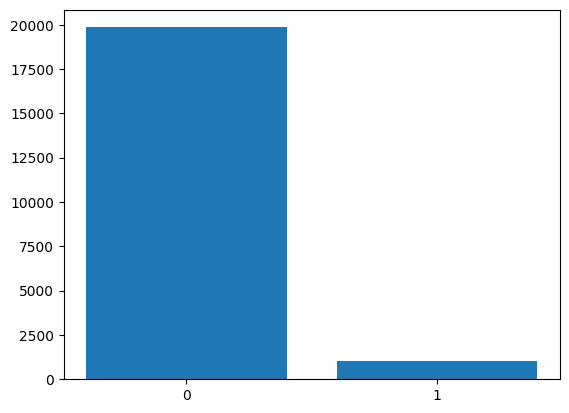

In [211]:
er_counts = inpatient['ER_flag'].value_counts()
categories = er_counts.index.astype(str)

plt.bar(categories, er_counts)

(0.0, 100.0)

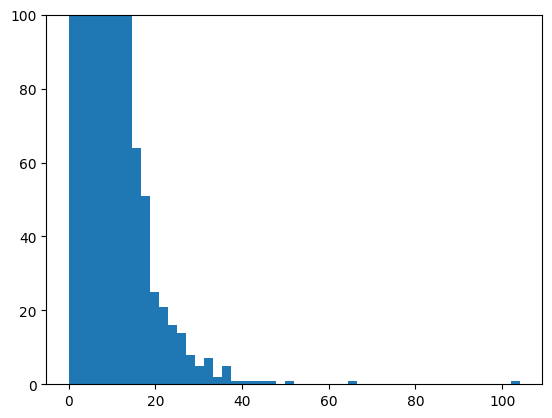

In [212]:
plt.hist(inpatient['LOS'], bins = 50)
plt.ylim((0,100))

(array([12.,  5.,  2.,  2.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 31.  ,  34.65,  38.3 ,  41.95,  45.6 ,  49.25,  52.9 ,  56.55,
         60.2 ,  63.85,  67.5 ,  71.15,  74.8 ,  78.45,  82.1 ,  85.75,
         89.4 ,  93.05,  96.7 , 100.35, 104.  ]),
 <BarContainer object of 20 artists>)

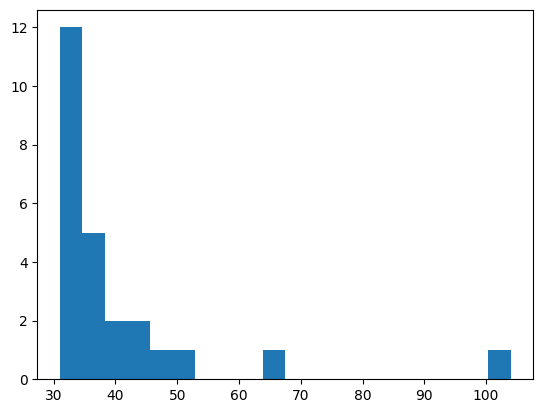

In [213]:
plt.hist(list(filter(lambda x: x > 30, inpatient['LOS'])), bins = 20)

<BarContainer object of 9 artists>

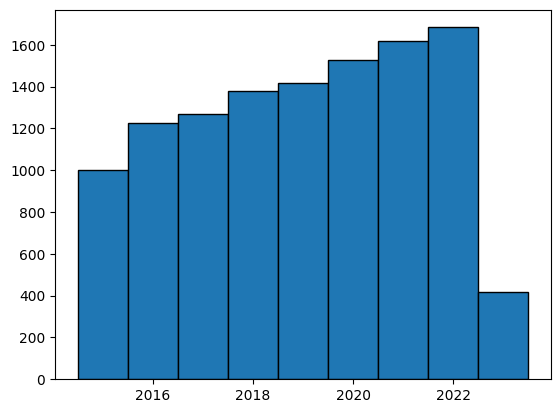

In [214]:
years = inpatient.groupby('YR')["BENE_ID"].nunique().index
unique_benes = inpatient.groupby('YR')["BENE_ID"].nunique()

plt.bar(years, unique_benes, width = 1, edgecolor = "black")

In [215]:
bene_years = inpatient.pivot_table(index='BENE_ID', columns='YR', aggfunc='size', fill_value=0)
bene_years

YR,2015,2016,2017,2018,2019,2020,2021,2022,2023
BENE_ID,,,,,,,,,
-10000010254618,1,0,0,0,0,0,0,0,0
-10000010254653,1,0,1,0,0,0,0,0,0
-10000010254656,0,0,1,1,0,0,0,1,0
-10000010254666,1,0,0,0,0,0,0,0,0
-10000010254682,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
-10000010288000,0,0,0,0,0,0,1,0,0
-10000010288005,0,0,0,1,1,0,0,0,0
-10000010288007,0,0,0,1,0,0,0,1,0


In [216]:
def get_cont_enrolled(init_year, end_year, df):
    '''Inputs a dataframe of CMS inpatient data and date range, and returns a dictionary of how many unique
    id's there are per year, as well as a dictionary of those unique id's per year'''


    select_years = df[df["YR"] < end_year]

    current_ids = select_years[select_years['YR'] == init_year]['BENE_ID'].unique()
    num_ids = [len(current_ids)]
    current_id_dict = {str(init_year) : list(current_ids)}
    
    for year in range(init_year + 1, end_year):
        
        current_ids = select_years[(select_years["BENE_ID"].isin(current_ids)) & 
                                   (select_years['YR'] == year)]["BENE_ID"].unique()
        num_ids.append(len(current_ids))

        current_id_dict[str(year)] = list(current_ids)
    
    return({"id_year_dict" : current_id_dict, 
            "nunique_df" : pd.DataFrame({"year" : range(init_year,end_year),
                         "n_unique" : num_ids})})



_2015_2024_ids = get_cont_enrolled(2015,2024, inpatient)

In [217]:
_2015_2024_ids["nunique_df"]
_2015_2024_ids['id_year_dict']['2023']

['-10000010255799',
 '-10000010256636',
 '-10000010257644',
 '-10000010258555',
 '-10000010262392',
 '-10000010271058',
 '-10000010277644',
 '-10000010278039',
 '-10000010279694',
 '-10000010282387',
 '-10000010282719',
 '-10000010287269']

In [227]:
inpatient[inpatient['BENE_ID'] == "-10000010255799"].groupby("YR")['BENE_ID'].count()

YR
2015    40
2016    51
2017    48
2018    49
2019    50
2020    45
2021    39
2022    41
2023     4
Name: BENE_ID, dtype: int64

In [233]:
inpatient[(inpatient['BENE_ID'] == "-10000010255799") & (inpatient["YR"] == 2023)]

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,YR,LOS,DRG,PRNCPAL_DGNS_CD,PTNT_DSCHRG_STUS_CD,CLM_IP_ADMSN_TYPE_CD,ER_flag,CLM_TOT_CHRG_AMT,CLM_PMT_AMT,NUM_DIAG,ICD_Description,DRG_TITLE
1037,-10000010255799,-10000930085744,2023-01-02,2023-01-02,2023,0,0,Y079,1,1,0,1026.20,1026.20,36,Unspecified perpetrator of maltreatment and ne...,NaN
1038,-10000010255799,-10000930085745,2023-01-16,2023-01-16,2023,0,951,Z608,1,1,0,846.35,846.35,36,Other problems related to social environment,OTHER FACTORS INFLUENCING HEALTH STATUS
1039,-10000010255799,-10000930085746,2023-02-13,2023-02-13,2023,0,951,Z608,1,1,0,375.98,375.98,36,Other problems related to social environment,OTHER FACTORS INFLUENCING HEALTH STATUS
1040,-10000010255799,-10000930085747,2023-02-20,2023-02-20,2023,0,951,Z608,1,1,0,2182.73,2182.73,36,Other problems related to social environment,OTHER FACTORS INFLUENCING HEALTH STATUS


In [ ]:
enrollment[(enrollment['BENE_ID'] == -10000010255799) ]

,BENE_ID,STATE_CODE,COUNTY_CD,ZIP_CD,BENE_BIRTH_DT,SEX_IDENT_CD,BENE_RACE_CD,ESRD_IND,BENE_ENROLLMT_REF_YR,RTI_RACE_CD,MDCR_status_code,MDCR_status_age_change_flag,Year,Age
224,-10000010255799,3,3060,85045,1919-08-18,1,1,Y,2015,1,11,0,2015,96
6209,-10000010255799,3,3060,85045,1919-08-18,1,1,Y,2016,1,11,0,2016,97
12512,-10000010255799,3,3060,85045,1919-08-18,1,1,Y,2017,1,11,0,2017,98
19135,-10000010255799,3,3060,85045,1919-08-18,1,1,Y,2018,1,11,0,2018,99
26152,-10000010255799,3,3060,85045,1919-08-18,1,1,Y,2019,1,11,0,2019,100
33611,-10000010255799,3,3060,85045,1919-08-18,1,1,Y,2020,1,11,0,2020,101
41468,-10000010255799,3,3060,85045,1919-08-18,1,1,Y,2021,1,11,0,2021,102
49725,-10000010255799,3,3060,85045,1919-08-18,1,1,Y,2022,1,11,0,2022,103
58416,-10000010255799,3,3060,85045,1919-08-18,1,1,Y,2023,1,11,0,2023,104
67616,-10000010255799,3,3060,85045,1919-08-18,1,1,Y,2024,1,11,0,2024,105


In [ ]:
for id in (_2015_2024_ids['id_year_dict']['2023']):
    print(enrollment[(enrollment['BENE_ID'] == int(id)) & (enrollment['Year'] == 2023)]["Age"])
    print(inpatient[(inpatient['BENE_ID'] == id) & (inpatient['YR'] == 2023)]["ICD_Description"])

In [270]:

enrollment.columns

Index(['BENE_ID', 'STATE_CODE', 'COUNTY_CD', 'ZIP_CD', 'BENE_BIRTH_DT',
       'SEX_IDENT_CD', 'BENE_RACE_CD', 'ESRD_IND', 'BENE_ENROLLMT_REF_YR',
       'RTI_RACE_CD', 'MDCR_status_code', 'MDCR_status_age_change_flag', 'YR',
       'Age'],
      dtype='object')

In [271]:
enrollment_select = enrollment[["BENE_ID", "STATE_CODE", "COUNTY_CD", "SEX_IDENT_CD","BENE_RACE_CD", "ESRD_IND","YR","Age"]]
inp_enr = inpatient.merge(enrollment_select, on = ["BENE_ID","YR"], how = "left")

In [285]:
rx_yr_cost.isna().sum()

BENE_ID           0
YR                0
TOT_RX_CST_AMT    0
dtype: int64

In [ ]:
inp_enr_rx = inp_enr.merge(rx_yr_cost, on = ["BENE_ID", "YR"], how = "left")
inp_enr_rx['TOT_RX_CST_AMT'].fillna(0, inplace=True)


In [ ]:
inp_enr_rx

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,YR,LOS,DRG,PRNCPAL_DGNS_CD,PTNT_DSCHRG_STUS_CD,CLM_IP_ADMSN_TYPE_CD,...,NUM_DIAG,ICD_Description,DRG_TITLE,STATE_CODE,COUNTY_CD,SEX_IDENT_CD,BENE_RACE_CD,ESRD_IND,Age,TOT_RX_CST_AMT
0,-10000010254618,-10000930037831,2015-03-25,2015-03-25,2015,0,551,S134XX,1,1,...,9,Sprain of ligaments of cervical spine,MEDICAL BACK PROBLEMS WITH MCC,1,1500,1,1,0,16,275.19
1,-10000010254653,-10000930038030,2015-09-24,2015-09-24,2015,0,951,Z3480,1,1,...,4,Encounter for supervision of other normal pre...,OTHER FACTORS INFLUENCING HEALTH STATUS,1,1400,2,1,0,33,0.00
2,-10000010254653,-10000930038031,2017-05-09,2017-05-10,2017,1,923,T7432X,1,3,...,3,"Child psychological abuse, confirmed","OTHER INJURY, POISONING AND TOXIC EFFECT DIAGN...",1,1400,2,1,0,35,0.00
3,-10000010254656,-10000930038162,2017-01-14,2017-01-14,2017,0,564,S8290X,1,1,...,4,Unspecified fracture of unspecified lower leg,OTHER MUSCULOSKELETAL SYSTEM AND CONNECTIVE TI...,1,1360,2,1,0,18,302.04
4,-10000010254656,-10000930038163,2018-03-17,2018-03-17,2018,0,951,Z3480,1,1,...,6,Encounter for supervision of other normal pre...,OTHER FACTORS INFLUENCING HEALTH STATUS,1,1360,2,1,0,19,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20862,-10000010288008,-10000931485965,2020-01-08,2020-01-14,2020,6,0,T50901A,1,3,...,12,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,75,0.00
20863,-10000010288008,-10000931485967,2020-10-23,2020-10-23,2020,0,0,T50901A,1,1,...,12,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,75,0.00
20864,-10000010288008,-10000931485969,2021-08-22,2021-08-23,2021,1,0,T50901A,1,1,...,13,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,76,0.00
20865,-10000010288008,-10000931485971,2021-09-13,2021-09-16,2021,3,0,T50901A,1,2,...,13,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,76,0.00
